<a href="https://colab.research.google.com/github/srinath9121/X-Pulse-Checker/blob/main/Notebook_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/X_logo_2023.svg/2560px-X_logo_2023.svg.png" alt="X Logo" width="300"/></center>

Here’s your updated description with **Twitter replaced by X (formerly Twitter)**, reworded for clarity and professionalism:

---

This notebook provides a streamlined way to analyze trending conversations on **X (formerly Twitter)** related to any topic of interest. While the current setup focuses on posts from and about the city of Seattle, it can be easily adapted to other topics, regions, or entities.

To speed up processing, especially for NLP tasks, enable GPU in Google Colab: go to **Runtime > Change runtime type**, select **GPU** under “Hardware Accelerator,” and click **Save**.

### What This Notebook Does:

1. Scrapes recent posts from **X** related to your chosen topic using the X API.
2. Extracts relevant entities using **Named Entity Recognition (NER)**.
3. Performs **Sentiment Analysis** on the collected posts.
4. Visualizes insights to understand the public pulse around the topic.

The notebook uses `tweepy` for API access, `flair` for NER and sentiment tasks, and `seaborn` for plotting—all made fast and free through Google Colab’s GPU support.

### NER (Named Entity Recognition):

NER extracts categories like **Person**, **Organization**, or **Location** from text. For example, from “George Washington went to Washington,” NER identifies “George Washington” as a person and “Washington” as a location. This allows structured analysis of what people and places are being discussed.

### Sentiment Analysis:

This measures whether a statement is **positive**, **negative**, or **neutral**. For instance, “I hated this movie” would be negative, while “I loved this movie” would be positive. It’s a key tool for understanding public opinion.

To run this project, you’ll need developer credentials for X. Sign up at: [https://developer.twitter.com/en/apps](https://developer.twitter.com/en/apps)

For advanced NLP models, see Flair’s GitHub tutorials: [https://github.com/zalandoresearch/flair](https://github.com/zalandoresearch/flair)


# Table of Contents

*   [Authenticate with X API](#Authenticate-with-X-API)
    *   [Enter Twitter Credentials](#Enter-Twitter-Credentials)
    *   [Lets start scraping!](#Lets-start-scraping!)
    *   [X Search API Inputs](#X-Search-API-Inputs)
*   [Data Sciencing](#Data-Sciencing)
    *   [Filter By Date Range](#Filter-By-Date-Range)
    *   [NER and Sentiment Analysis](#NER-and-Sentiment-Analysis)
*   [Visualize!](#Visualize!)
    *   [Visualize Top TAGs](#Visualize-Top-TAGs)
    *   [Get the Average Polarity Distribution](#Get-the-Average-Polarity-Distribution)
    *   [Word Cloud](#Word-Cloud)
    *   [Build Word Cloud For Top TAGs](#Build-Word-Cloud-For-Top-TAGs)

To get up and running, we need to import a bunch of stuff and install Flair. Run through the next 3 cells.

In [26]:
# import lots of stuff
import sys
import os
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import clear_output
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [27]:

!pip install --upgrade git+https://github.com/flairNLP/flair.git

clear_output()

In [28]:
# import Flair stuff
from flair.data import Sentence
from flair.models import SequenceTagger

tagger = SequenceTagger.load('ner')

clear_output()

In [29]:
#import Flair Classifier
from flair.models import TextClassifier

classifier = TextClassifier.load('en-sentiment')

clear_output()

## Authenticate with X API

## Enter X Credentials

In [30]:
# --- X API AUTHENTICATION CELL ---

import tweepy

# 🔐 Paste your Bearer Token here
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAADKN5QEAAAAASPTV%2FxGnVyi9FI1KB2pqBgMI63U%3DmI512JmpndTsLWSG7dUmHe6KvNVahGBsBSPQTuAWFZAyP63vSD"

try:
    client = tweepy.Client(bearer_token=BEARER_TOKEN)
    # Simple test to validate credentials
    user_test = client.get_user(username="elonmusk")
    print(f"✅ Connected. Test user ID: {user_test.data.id}")
except Exception as e:
    print("❌ Authentication failed:", e)


✅ Connected. Test user ID: 44196397


## **Lets start scraping!**

### X Search API Inputs

In [31]:
import pandas as pd
import time

# ----------------- SEARCH SETTINGS -----------------
QUERY = "AI -is:retweet lang:en"  # Change this to your topic
MAX_RESULTS = 25                 # Max allowed per request
TOTAL_TWEETS = 25                # Total tweets to collect

# ----------------- SCRAPE FUNCTION -----------------
def fetch_tweets(query, max_results=25, total=25):
    tweets = []
    next_token = None
    # Check if the 'client' object is defined from the authentication cell
    if 'client' not in globals():
        print("❌ Error: X API client not authenticated. Please run the authentication cell first.")
        return []

    while len(tweets) < total:
        try:
            response = client.search_recent_tweets(
                query=query,
                tweet_fields=["created_at", "public_metrics", "lang"],
                max_results=max_results,
                next_token=next_token
            )
            if response.data:
                tweets.extend(response.data)
                next_token = response.meta.get("next_token")
                print(f"Fetched: {len(tweets)} tweets so far...")
                if not next_token:
                    break
                time.sleep(2)
            else:
                print("No data returned.")
                break
        except Exception as e:
            print("❌ Error during scraping:", e)
            break
    return tweets[:total]

# ----------------- RUN SCRAPE -----------------
raw_tweets = fetch_tweets(QUERY, MAX_RESULTS, TOTAL_TWEETS)

# ----------------- STRUCTURE TO DATAFRAME -----------------
def tweets_to_df(tweets):
    data = []
    for tweet in tweets:
        metrics = tweet.public_metrics
        data.append({
            'id': tweet.id,
            'created_at': tweet.created_at,
            'text': tweet.text,
            'like_count': metrics.get('like_count', 0),
            'retweet_count': metrics.get('retweet_count', 0),
            'reply_count': metrics.get('reply_count', 0),
        })
    return pd.DataFrame(data)

df = tweets_to_df(raw_tweets)
print(f"\n✅ Collected {len(df)} tweets into DataFrame")
display(df.head())

Fetched: 24 tweets so far...
❌ Error during scraping: 429 Too Many Requests
Too Many Requests

✅ Collected 24 tweets into DataFrame


,id,created_at,text,like_count,retweet_count,reply_count
0,1988092600952500645,2025-11-11 03:53:07+00:00,⚡ Token Signal : $groupie ⚡\n🧫 Holder - 22 \n🧫 - 0x3ba52fc817815c4e9c666aca4176d52a61ed274e \n💎 AI Alert 🌐 https://t.co/UnXrzMwpD7 👈\n🤖 Check Analyze 👉👉 https://t.co/1mrbJkarwF ⬅️\n🔃- 30% lower fees than Photon/BullX -🔃 https://t.co/SaNOzhp42u,0,1,0
1,1988092600667304217,2025-11-11 03:53:07+00:00,@ekpi_ @irys_xyz @irys_xyz is building a platform that connects creators with AI tools seamlessly.,0,0,0
2,1988092600205930678,2025-11-11 03:53:07+00:00,code AI innovation before believe in better days. mind energy time smile👲📦🚁👋824 https://t.co/kFKhmLF9Mp,0,0,0
3,1988092599174131745,2025-11-11 03:53:07+00:00,@gaumishang @GundiThore @seahawkgirl84 @D_the_Designer @Alekalucard @Heartwords3 @techhalla @yannToskov @SIN_AI_1 @Protein_oppa Schmoo,0,0,0
4,1988092598750507493,2025-11-11 03:53:07+00:00,"🔥 Download the app &amp; collect letters to win a total prize pool of 100,000 USD!\n🧩 INTER → 5 USD\n🧩 INTERLINK → 50 USD\n🧩 INTERLINKLABS → 1,000 USD\n🧩 INTERLINKLABSITLX → 10,000 USD\n🎯 Start now: https://t.co/yaBKjOPN42\n#InterLink #4MHumanNodeCelebration",0,0,0


### Data Science

In [32]:
pd.set_option('display.max_colwidth', None)

# load it into a pandas dataframe
tweet_df = tweets_to_df(raw_tweets)
tweet_df.to_csv('tweets.csv')
tweet_df.head()

,id,created_at,text,like_count,retweet_count,reply_count
0,1988092600952500645,2025-11-11 03:53:07+00:00,⚡ Token Signal : $groupie ⚡\n🧫 Holder - 22 \n🧫 - 0x3ba52fc817815c4e9c666aca4176d52a61ed274e \n💎 AI Alert 🌐 https://t.co/UnXrzMwpD7 👈\n🤖 Check Analyze 👉👉 https://t.co/1mrbJkarwF ⬅️\n🔃- 30% lower fees than Photon/BullX -🔃 https://t.co/SaNOzhp42u,0,1,0
1,1988092600667304217,2025-11-11 03:53:07+00:00,@ekpi_ @irys_xyz @irys_xyz is building a platform that connects creators with AI tools seamlessly.,0,0,0
2,1988092600205930678,2025-11-11 03:53:07+00:00,code AI innovation before believe in better days. mind energy time smile👲📦🚁👋824 https://t.co/kFKhmLF9Mp,0,0,0
3,1988092599174131745,2025-11-11 03:53:07+00:00,@gaumishang @GundiThore @seahawkgirl84 @D_the_Designer @Alekalucard @Heartwords3 @techhalla @yannToskov @SIN_AI_1 @Protein_oppa Schmoo,0,0,0
4,1988092598750507493,2025-11-11 03:53:07+00:00,"🔥 Download the app &amp; collect letters to win a total prize pool of 100,000 USD!\n🧩 INTER → 5 USD\n🧩 INTERLINK → 50 USD\n🧩 INTERLINKLABS → 1,000 USD\n🧩 INTERLINKLABSITLX → 10,000 USD\n🎯 Start now: https://t.co/yaBKjOPN42\n#InterLink #4MHumanNodeCelebration",0,0,0


In [33]:
#@title Filter By Date Range
today = datetime.now().date()
yesterday = today - timedelta(1)

start_dt = '' #@param {type:"date"}
end_dt = '' #@param {type:"date"}

if start_dt == '':
  start_dt = yesterday
else:
  start_dt = datetime.strptime(start_dt, '%Y-%m-%d').date()

if end_dt == '':
  end_dt = today
else:
  end_dt = datetime.strptime(end_dt, '%Y-%m-%d').date()

# Convert 'created_at' to datetime and then to date for comparison
tweet_df['created_at'] = pd.to_datetime(tweet_df['created_at'])
tweet_df['tweet_dt'] = tweet_df['created_at'].dt.date

tweet_df = tweet_df[(tweet_df['tweet_dt'] >= start_dt)
                    & (tweet_df['tweet_dt'] <= end_dt)]
tweet_df.shape

(24, 7)

### NER and Sentiment Analysis

In [34]:
# predict NER and Sentiment Analysis
nerlst = []

for index, row in tqdm(tweet_df.iterrows(), total=tweet_df.shape[0]):
  cleanedTweet = row['text'].replace("#", "")
  sentence = Sentence(cleanedTweet, use_tokenizer=True)

  # predict NER tags
  tagger.predict(sentence)

  # get ner
  ners = sentence.to_dict().get('entities', []) # Use .get() with a default empty list

  # predict sentiment
  classifier.predict(sentence)

  label = sentence.labels[0]
  response = {'result': label.value, 'polarity':label.score}

  # get hashtags
  hashtags = re.findall(r'#\w+', row['text'])
  if len(hashtags) >= 1:
    for hashtag in hashtags:
      ners.append({ 'type': 'Hashtag', 'text': hashtag })

  for ner in ners:
    adj_polarity = response['polarity']
    if response['result'] == 'NEGATIVE':
      adj_polarity = response['polarity'] * -1
    try:
      ner['type']
    except:
      ner['type'] = ''
    nerlst.append([ row['tweet_dt'], row['id'], row['text'], ner.get('type', ''), ner.get('text', ''), response['result'], # Use .get() for ner type and text
                   response['polarity'], adj_polarity, row['like_count'], row['reply_count'],
                  row['retweet_count'] ])

clear_output()

In [35]:
df_ner = pd.DataFrame(nerlst, columns=['tweet_dt', 'id', 'tweet', 'tag_type', 'tag', 'sentiment', 'polarity',
                                       'adj_polarity','like_count', 'reply_count', 'retweet_count'])
display(df_ner.head())

,tweet_dt,id,tweet,tag_type,tag,sentiment,polarity,adj_polarity,like_count,reply_count,retweet_count
0,2025-11-11,1988092598750507493,"🔥 Download the app &amp; collect letters to win a total prize pool of 100,000 USD!\n🧩 INTER → 5 USD\n🧩 INTERLINK → 50 USD\n🧩 INTERLINKLABS → 1,000 USD\n🧩 INTERLINKLABSITLX → 10,000 USD\n🎯 Start now: https://t.co/yaBKjOPN42\n#InterLink #4MHumanNodeCelebration",Hashtag,#InterLink,POSITIVE,0.862735,0.862735,0,0,0
1,2025-11-11,1988092598750507493,"🔥 Download the app &amp; collect letters to win a total prize pool of 100,000 USD!\n🧩 INTER → 5 USD\n🧩 INTERLINK → 50 USD\n🧩 INTERLINKLABS → 1,000 USD\n🧩 INTERLINKLABSITLX → 10,000 USD\n🎯 Start now: https://t.co/yaBKjOPN42\n#InterLink #4MHumanNodeCelebration",Hashtag,#4MHumanNodeCelebration,POSITIVE,0.862735,0.862735,0,0,0
2,2025-11-11,1988092593818018066,"✨ Just found this stunning AI creation on #CoScription! https://t.co/2diN6QB2Yr\n\n💰 By using trending #AI models to create, everyone can earn points towards a future airdrop.\n\n🤩 Use my referral code 7d3da0 for an extra bonus. @CoScriptionAI\n\n#UserOwnedAI",Hashtag,#CoScription,POSITIVE,0.999397,0.999397,0,0,0
3,2025-11-11,1988092593818018066,"✨ Just found this stunning AI creation on #CoScription! https://t.co/2diN6QB2Yr\n\n💰 By using trending #AI models to create, everyone can earn points towards a future airdrop.\n\n🤩 Use my referral code 7d3da0 for an extra bonus. @CoScriptionAI\n\n#UserOwnedAI",Hashtag,#AI,POSITIVE,0.999397,0.999397,0,0,0
4,2025-11-11,1988092593818018066,"✨ Just found this stunning AI creation on #CoScription! https://t.co/2diN6QB2Yr\n\n💰 By using trending #AI models to create, everyone can earn points towards a future airdrop.\n\n🤩 Use my referral code 7d3da0 for an extra bonus. @CoScriptionAI\n\n#UserOwnedAI",Hashtag,#UserOwnedAI,POSITIVE,0.999397,0.999397,0,0,0


In [36]:
# -------------------- Aggregation Per Tag --------------------

# The banned_words list is included here for clarity, but filtering has already been done in a previous cell
banned_words = ['Seattle', 'WA', '#Seattle', '#seattle', 'Washington', 'SEATTLE', 'WASHINGTON',
                'seattle', 'Seattle WA', 'seattle wa','Seattle, WA', 'Seattle WA USA',
                'Seattle, Washington', 'Seattle Washington', 'Wa', 'wa', '#Wa',
                '#wa', '#washington', '#Washington', '#WA', '#PNW', '#pnw', '#northwest']

# Filter out rows where the 'tag' is in the banned_words list
df_ner_filtered = df_ner[~df_ner['tag'].isin(banned_words)].copy()


# Group by tag and tag_type to calculate metrics using the filtered DataFrame
grouped_df = df_ner_filtered.groupby(['tag', 'tag_type']).agg({
    'adj_polarity': 'mean',
    'like_count': 'sum',
    'reply_count': 'sum',
    'retweet_count': 'sum',
    'tag': 'count'  # frequency
}).rename(columns={'tag': 'Frequency'}).reset_index()

# Assign sentiment category
grouped_df['Sentiment'] = grouped_df['adj_polarity'].apply(lambda x: 'POSITIVE' if x >= 0 else 'NEGATIVE')

# Show top 10 trending tags
display(grouped_df.sort_values(by='Frequency', ascending=False).head(10))

,tag,tag_type,adj_polarity,like_count,reply_count,retweet_count,Frequency,Sentiment
0,#4MHumanNodeCelebration,Hashtag,0.845095,0,0,0,6,POSITIVE
3,#InterLink,Hashtag,0.845095,0,0,0,6,POSITIVE
1,#AI,Hashtag,0.999397,0,0,0,1,POSITIVE
2,#CoScription,Hashtag,0.999397,0,0,0,1,POSITIVE
4,#UserOwnedAI,Hashtag,0.999397,0,0,0,1,POSITIVE
5,#altcoins,Hashtag,-0.998936,0,0,0,1,NEGATIVE
6,#memecoins,Hashtag,-0.998936,0,0,0,1,NEGATIVE


In [37]:
# Sort the grouped_df by Frequency in descending order
sorted_grouped_df = grouped_df.sort_values(by='Frequency', ascending=False)
display(sorted_grouped_df)

,tag,tag_type,adj_polarity,like_count,reply_count,retweet_count,Frequency,Sentiment
0,#4MHumanNodeCelebration,Hashtag,0.845095,0,0,0,6,POSITIVE
3,#InterLink,Hashtag,0.845095,0,0,0,6,POSITIVE
1,#AI,Hashtag,0.999397,0,0,0,1,POSITIVE
2,#CoScription,Hashtag,0.999397,0,0,0,1,POSITIVE
4,#UserOwnedAI,Hashtag,0.999397,0,0,0,1,POSITIVE
5,#altcoins,Hashtag,-0.998936,0,0,0,1,NEGATIVE
6,#memecoins,Hashtag,-0.998936,0,0,0,1,NEGATIVE


In [38]:
display(sorted_grouped_df[['tag', 'Frequency', 'adj_polarity']].head(10))

,tag,Frequency,adj_polarity
0,#4MHumanNodeCelebration,6,0.845095
3,#InterLink,6,0.845095
1,#AI,1,0.999397
2,#CoScription,1,0.999397
4,#UserOwnedAI,1,0.999397
5,#altcoins,1,-0.998936
6,#memecoins,1,-0.998936


In [39]:
sorted_grouped_df = grouped_df.sort_values(by='Frequency', ascending=False)
display(sorted_grouped_df)

,tag,tag_type,adj_polarity,like_count,reply_count,retweet_count,Frequency,Sentiment
0,#4MHumanNodeCelebration,Hashtag,0.845095,0,0,0,6,POSITIVE
3,#InterLink,Hashtag,0.845095,0,0,0,6,POSITIVE
1,#AI,Hashtag,0.999397,0,0,0,1,POSITIVE
2,#CoScription,Hashtag,0.999397,0,0,0,1,POSITIVE
4,#UserOwnedAI,Hashtag,0.999397,0,0,0,1,POSITIVE
5,#altcoins,Hashtag,-0.998936,0,0,0,1,NEGATIVE
6,#memecoins,Hashtag,-0.998936,0,0,0,1,NEGATIVE


### **Calculate Frequency, Likes, Replies, Retweets and Average Polarity per Tag.**

In [40]:
# Create an overall Sentiment column based on the Average Polarity of the Tag.
grouped_df['Sentiment'] = np.where(grouped_df['adj_polarity'] >= 0, 'POSITIVE', 'NEGATIVE')
display(grouped_df.head())

,tag,tag_type,adj_polarity,like_count,reply_count,retweet_count,Frequency,Sentiment
0,#4MHumanNodeCelebration,Hashtag,0.845095,0,0,0,6,POSITIVE
1,#AI,Hashtag,0.999397,0,0,0,1,POSITIVE
2,#CoScription,Hashtag,0.999397,0,0,0,1,POSITIVE
3,#InterLink,Hashtag,0.845095,0,0,0,6,POSITIVE
4,#UserOwnedAI,Hashtag,0.999397,0,0,0,1,POSITIVE


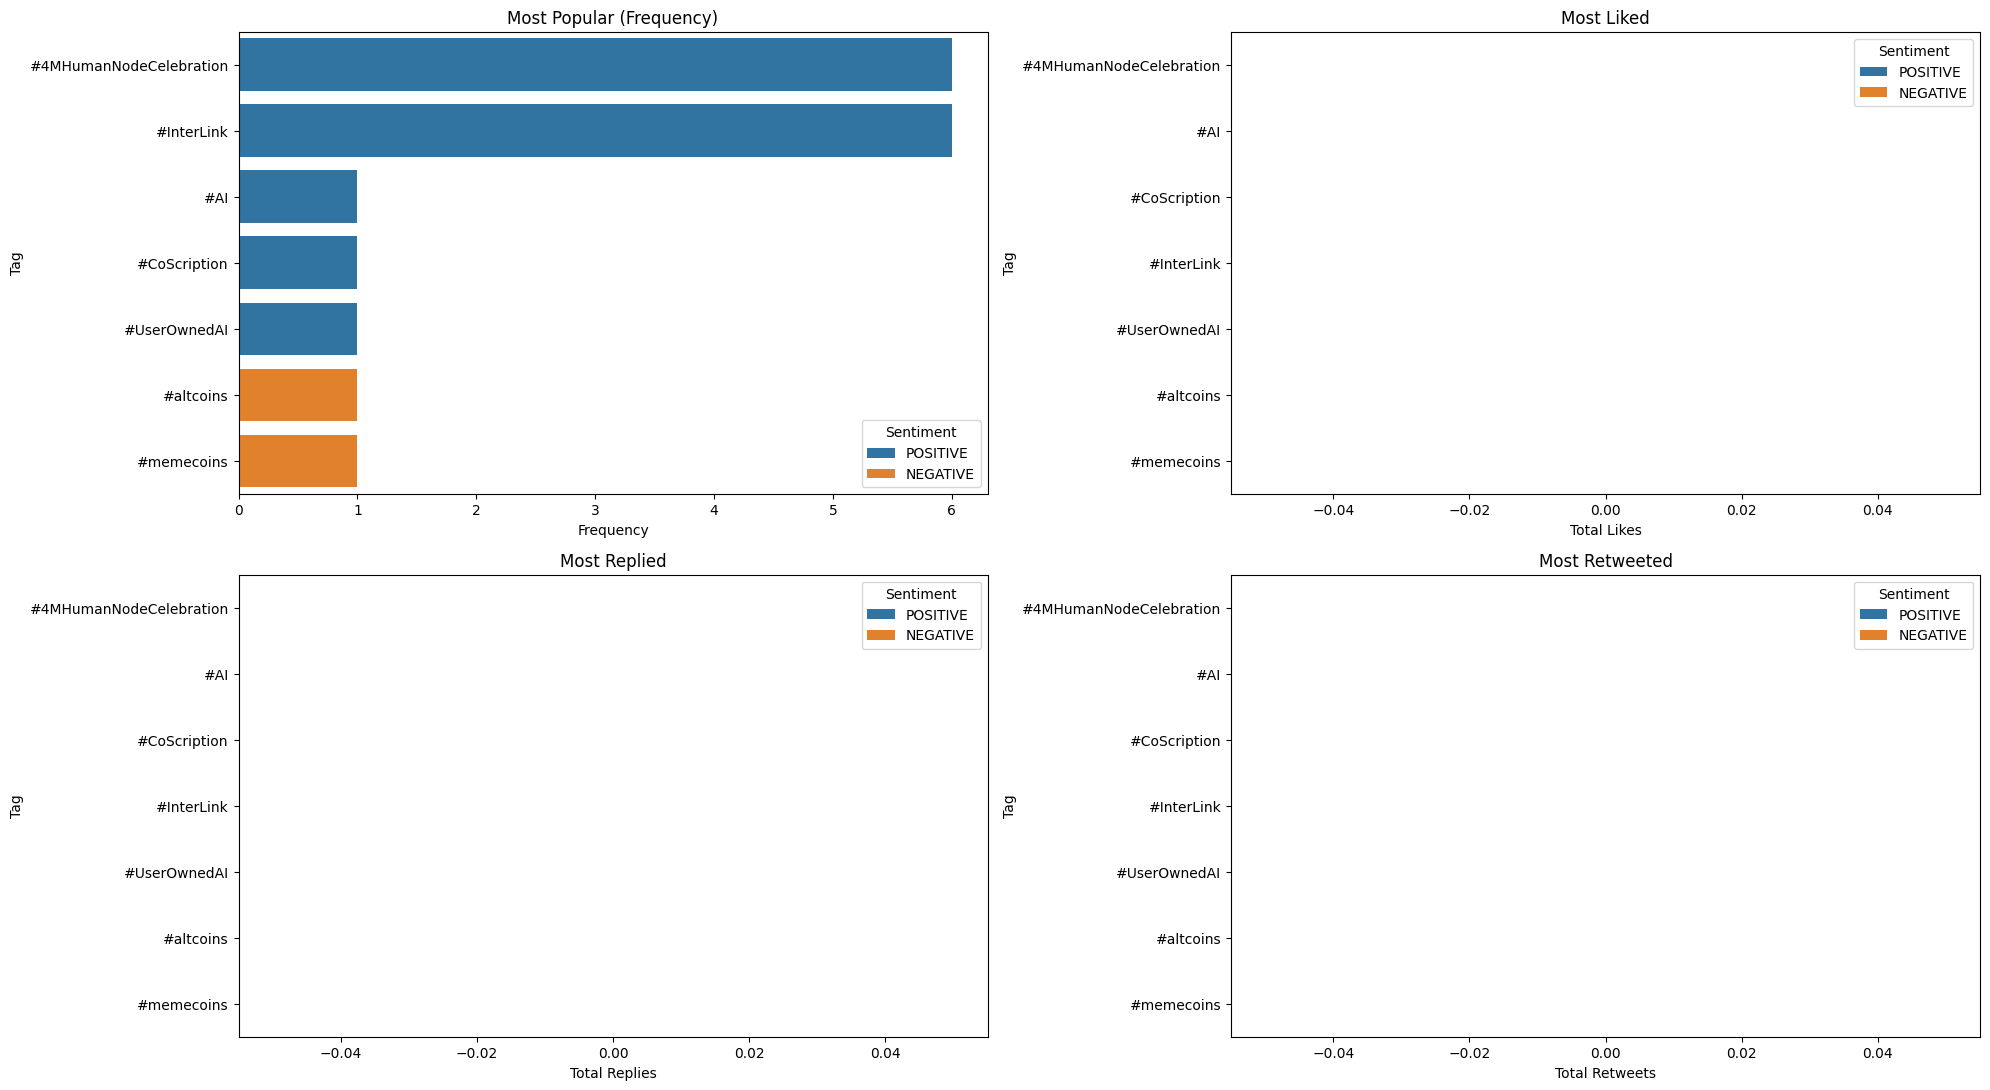

In [41]:
#@title Visualize Top TAGs
Filter_TAG = False #@param {type:"boolean"}
TAG = 'Person' #@param ["Hashtag", "Person", "Location", "Organization"]
#@markdown ###Pick how many tags to display per chart:
Top_N = 10 #@param {type:"integer"}

# get TAG value - The logic here needs to be adjusted based on the tag_type column in grouped_df
# Let's assume the tag_type in grouped_df matches the dropdown values (Hashtag, Person, Location, Organization)
# If TAG != 'Hashtag':
#   TAG = TAG[:3].upper() # This logic is not necessary if tag_type column already contains full names


if Filter_TAG:
  # Filter by tag_type column which should match the TAG dropdown value
  filtered_group = grouped_df[(grouped_df['tag_type'] == TAG)].copy()
else:
  filtered_group = grouped_df.copy() # Work on a copy to avoid modifying the original grouped_df


# plot the figures
fig = plt.figure(figsize=(20, 16))
fig.subplots_adjust(hspace=0.2, wspace=0.5)

# Most Popular Tweets (based on Frequency)
ax1 = fig.add_subplot(321)
filtered_group_freq = filtered_group.sort_values(['Frequency'], ascending=False).head(Top_N)
sns.barplot(x="Frequency", y="tag", data=filtered_group_freq, hue="Sentiment", ax=ax1) # Specify ax=ax1

# Most Liked Tweets
ax2 = fig.add_subplot(322)
filtered_group_likes = filtered_group.sort_values(['like_count'], ascending=False).head(Top_N) # Corrected column name
sns.barplot(x="like_count", y="tag", data=filtered_group_likes, hue="Sentiment", ax=ax2) # Corrected column name and specify ax=ax2

# Most Replied Tweets
ax3 = fig.add_subplot(323)
filtered_group_replies = filtered_group.sort_values(['reply_count'], ascending=False).head(Top_N) # Corrected column name
sns.barplot(x="reply_count", y="tag", data=filtered_group_replies, hue="Sentiment", ax=ax3) # Corrected column name and specify ax=ax3

# Most Retweeted Tweets
ax4 = fig.add_subplot(324)
filtered_group_retweets = filtered_group.sort_values(['retweet_count'], ascending=False).head(Top_N) # Corrected column name
sns.barplot(x="retweet_count", y="tag", data=filtered_group_retweets, hue="Sentiment", ax=ax4) # Corrected column name and specify ax=ax4


ax1.title.set_text('Most Popular (Frequency)') # Added 'Frequency' for clarity
ax2.title.set_text('Most Liked')
ax3.title.set_text('Most Replied')
ax4.title.set_text('Most Retweeted')

ax1.set_ylabel('Tag') # Added y-label
ax1.set_xlabel('Frequency') # Added x-label
ax2.set_ylabel('Tag') # Added y-label
ax2.set_xlabel('Total Likes') # Added x-label
ax3.set_ylabel('Tag') # Added y-label
ax3.set_xlabel('Total Replies') # Added x-label
ax4.set_ylabel('Tag') # Added y-label
ax4.set_xlabel('Total Retweets') # Added x-label

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Ensure plot is displayed

## **Get the Average Polarity Distribution.**

/tmp/ipython-input-470362286.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=filtered_group, x='adj_polarity', shade=True)


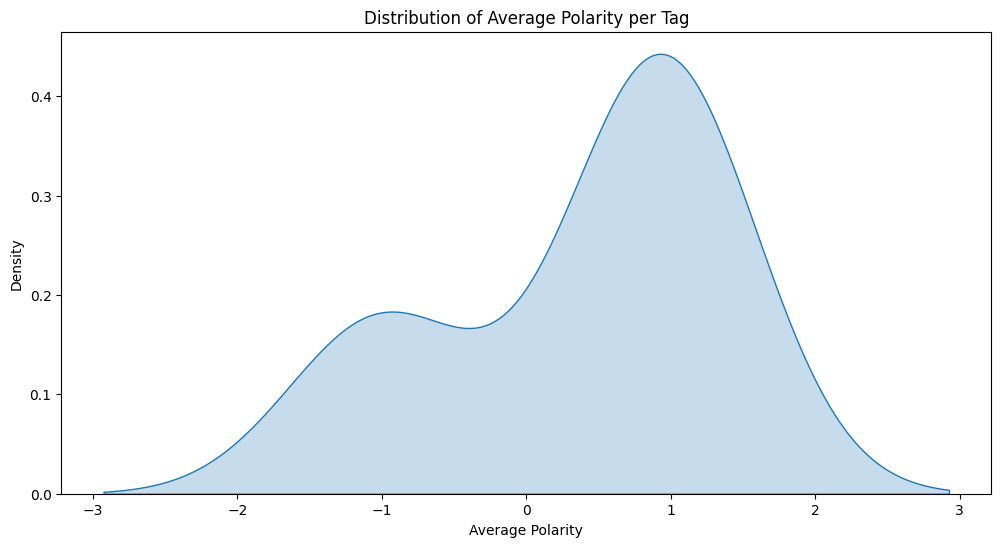

In [42]:
# Get the Average Polarity Distribution.
fig = plt.figure(figsize=(12, 6))

# Use sns.kdeplot for density plot as sns.distplot is deprecated
# Use the correct DataFrame (filtered_group, which is already defined based on Filter_TAG and TAG)
# Use the correct column name for average polarity ('adj_polarity')
sns.kdeplot(data=filtered_group, x='adj_polarity', shade=True)

plt.title('Distribution of Average Polarity per Tag') # Add a title for clarity
plt.xlabel('Average Polarity') # Add x-label
plt.ylabel('Density') # Add y-label
plt.show() # Ensure the plot is displayed